### Youtube narration of project: https://www.youtube.com/watch?v=ZXbiZssiKUg

- 1. Research Question and Background Information
- 2.1 Gather full path of pdfs.
    - 2.2 Create custom index of pdfs.
- 3.1 Extract original OCR and Tesseract OCR of pdf.
    - 3.2 Split output by page break.
    - 3.3 Add hyperlink colum to split output.
- 4.1 Variable Definitions
- 5.1 Variable Summary Statistics
- 6.1 Visualization of a dependent variable
- 7.1 Visualization summary
- 8.1 Visualization of a independent variable
- 9.1 Visualization summary 2
- 10.1 Bivariate relationship
- 11.1 Visualization sumamry 3
- 12.1 Regresssion Analysis
- 13.1 Control variable justification
- 14.1 Interpret the independent bivariate variable
- 15.1 Interpret the independent multivariate variable
- 16.1 Conduct a hypothesis test
- 17.1 Overall findings
- 18.1 Closing thoughts

<a id='1.'></a>
### 1. Research Question and Background Information

2. The objective of this final project was to build a scalable tool to extract the original optical character recognition (OCR) embedded in a pdf, to also implement the Tesseract Long Short Term Memory (LSTM) Recurrent Neural Network (RNN) OCR on the same pdf, and then finally package both results into a useable csv format for downstream classification work. 

To complete the above I spent a significant amount of time identifying the proper tools, setting up my environment and optimizing for both horizontal and vertical scalability in my scripting architecture. With that aside the code itself is quite simple, via the utilization of package APIs. 

I commented my code with the intent that a naive natural language processing scientist (a potential employer) may digest my work.

The package documentation that made my project possible:
- Tesseract (open-source OCR software, in C++) - https://tesseract-ocr.github.io/tessdoc/#tesseract-user-manual
- pytesseract (Tesseract wrapper for python) - https://github.com/madmaze/pytesseract
- PyPDF2DF2 (pdf reader to extract original ocr) - https://pythonhosted.org/PyPDF2DF2/
- fitz (pdf reader to convert pdfs to pngs) - https://pymupdf.readthedocs.io/en/latest/
- tqdm (progress bar to monitor processing progress) - https://tqdm.github.io/
- pandas (packaging data) - https://pandas.pydata.org/docs/

3. The dataset I will be using is from a small github repo - https://github.com/miollek/Free-Database-Books


In [2]:
#import packages
import os
import PyPDF2
import traceback
import pandas as pd
from tqdm import tqdm
import pytesseract
import fitz

<a id='2.1'></a>
### 2.1. Gather full path of every pdf. 

In this section below I walk through the defined directory, and subdirectories, searching for pdfs. Once found, I append the full path of the pdf (including filename) into a list. 

The function below by design may handle any folder structure.  

In [2]:
#set constants:
dirName = r'D:\fast_envs\pytorch_gpu2\Free-Database-Books-master'

In [3]:
#get list of all .pdfs in dirName
def getListOfFiles(dirName):
    # create a list of pdf files and their full path
    listOfFile = os.listdir(dirName)
    allFiles = list()
       
    # Iterate over all the entries
    for entry in tqdm(listOfFile):
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            #append results to metadata lists
            if fullPath.endswith('.pdf'):
                fullPath = fullPath.replace('\\', '/')#fix formatting
                allFiles.append(fullPath) #send to list
    return allFiles

pdf_dirs = getListOfFiles(dirName)

  0%|          | 0/1 [00:00<?, ?it/s]





100%|██████████| 1/1 [00:00<00:00, 83.55it/s]


In [4]:
#inspet results
pdf_dirs[:10]

['D:/fast_envs/pytorch_gpu2/Free-Database-Books-master/Free-Database-Books-master/book/Graph Databases.pdf',
 'D:/fast_envs/pytorch_gpu2/Free-Database-Books-master/Free-Database-Books-master/book/Learning Azure DocumentDB.pdf',
 'D:/fast_envs/pytorch_gpu2/Free-Database-Books-master/Free-Database-Books-master/book/Learning Neo4j.pdf',
 'D:/fast_envs/pytorch_gpu2/Free-Database-Books-master/Free-Database-Books-master/book/Learning PostgreSQL.pdf',
 'D:/fast_envs/pytorch_gpu2/Free-Database-Books-master/Free-Database-Books-master/book/Microsoft SQL Azure Enterprise Application Development.pdf',
 'D:/fast_envs/pytorch_gpu2/Free-Database-Books-master/Free-Database-Books-master/book/Microsoft SQL Server 2012 Integration Services - An Expert Cookbook.pdf',
 'D:/fast_envs/pytorch_gpu2/Free-Database-Books-master/Free-Database-Books-master/book/MongoDB Basics.pdf',
 'D:/fast_envs/pytorch_gpu2/Free-Database-Books-master/Free-Database-Books-master/book/MySQL for Python.pdf',
 'D:/fast_envs/pytorch_g

<a id='2.2'></a>
### 2.2 Create custom index of pdfs.

The objective of this section is to generate a custom index to use as a primary key in the final output. Such a key would be useful in joining tables, such as classification work, and raw files. 

In [5]:
#made custom index for pdf_dir
def custom_index(pdf_dirs):
    pdf_id = [] #empty list
    id = 0 #base id
    for dir in pdf_dirs: #loop through dirs and set unique id
        id += 1 
        new_id = "C"+str(id)
        pdf_id.append(new_id)
    return pdf_id

pdf_id = custom_index(pdf_dirs)

In [6]:
#inspect pdf_id
pdf_id[:10]

['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']

<a id='3.1.'></a>
### 3.1 Extract Original and Tesseract OCR.

This is the meat of the project, where I extract the pdf contents and package it into a csv. 

It runs as follows:
1) attempt to open pdf, if for any reason fails, print error in terminal.
2) get page length of pdf
3) extract original ocr (old_ocr) and Tesseract ocr (new_ocr) up to 10 pages. 
4) append results to csv.

It is worth mentioning that accuracy enhancements were made in the new_ocr extraction via the function fitz.Matrix(x,y). I increased the pixel density of the pdf->png conversion by 4. This enhancement was achieved via pure trial-and-error. To go any higher than for obtains negligible increases in accuracy, and as a byproduct unnecessarily increases processing runtime.

Also worth mentioning, with regards to overall function architecture, I decided to append results to the csv on a file-by-file basis to ensure that work isn't lost when running at scale (at thousands of pdfs). During development I came across some pdfs that would not error-out, causing my for-loop to infinitely hang. I could not find the reason for this and changed my code as a result. 

In [7]:
#pass index and pdf through ocr extractor, and append results to csv
def getListOfOCR(pdf_id, pdf_dirs):
    #call tesseract instance
    pytesseract.pytesseract.tesseract_cmp = r"C:\Program Files (x86)\Tesseract-OCR\tesseract.exe"

    #open pdf, search all pages, append results to list
    for ID, item in tqdm(zip(pdf_id, pdf_dirs)):
        
        C_ID = ID
        dir = item
        myText_old = None
        myText_new = None

        try: 
            pdf = PyPDF2.PdfFileReader(item, strict=False) #open pdf
            doc = fitz.open(dir) #open pdf
            numPages = pdf.getNumPages() #get page number

            #read first page of old ocr, extract text and add Carl's custom pagebreak
            pageObj = pdf.getPage(0)
            myText_old = pageObj.extractText()
            myText_old = myText_old + '_OldPageBreak_'
            
            #read first page of new ocr, extract text, and add Carl's custom pagebreak
            page = doc.load_page(0) #access specific page
            pix = page.get_pixmap(matrix = (fitz.Matrix(4,4))) #getpixel map of page
            filename = '{}{}{}'.format('temp_img_', 0, '.png') 
            pix.save(filename) #write page to png, save
            myText_new = pytesseract.image_to_string(filename) #re-OCR with tesseract and save output to string, LSTM RNN by default. 
            myText_new = myText_new + "_NewPageBreak_"
            os.remove(filename) #delete png #new ocr

            #page 1
            if numPages > 1:
                pageObj = pdf.getPage(1)#read page
                
                #old ocr 
                myText_old = myText_old + pageObj.extractText()
                myText_old = myText_old + "_OldPageBreak_"
                
                #new ocr
                page = doc.load_page(1) #access specific page
                pix = page.get_pixmap(matrix = (fitz.Matrix(4,4))) #getpixel map of page
                filename = '{}{}{}'.format('temp_img_', 1, '.png') 
                pix.save(filename) #write page to png, save
                myText_new = myText_new + pytesseract.image_to_string(filename) #re-OCR and save output to string 
                myText_new = myText_new + "_NewPageBreak_"
                os.remove(filename) #delete png 

            #page 2
            if numPages > 2:
                pageObj = pdf.getPage(2)#read page
                
                #old ocr 
                myText_old = myText_old + pageObj.extractText()
                myText_old = myText_old + "_OldPageBreak_"
                
                #new ocr
                page = doc.load_page(2) #access specific page
                pix = page.get_pixmap(matrix = (fitz.Matrix(4,4))) #getpixel map of page
                filename = '{}{}{}'.format('temp_img_', 2, '.png') 
                pix.save(filename) #write page to png, save
                myText_new = myText_new + pytesseract.image_to_string(filename) #re-OCR and save output to string 
                myText_new = myText_new + "_NewPageBreak_"
                os.remove(filename) #delete png 

            #page 3
            if numPages > 3:
                pageObj = pdf.getPage(3)#read page
                
                #old ocr 
                myText_old = myText_old + pageObj.extractText()
                myText_old = myText_old + "_OldPageBreak_"
                
                #new ocr
                page = doc.load_page(3) #access specific page
                pix = page.get_pixmap(matrix = (fitz.Matrix(4,4))) #getpixel map of page
                filename = '{}{}{}'.format('temp_img_', 3, '.png') 
                pix.save(filename) #write page to png, save
                myText_new = myText_new + pytesseract.image_to_string(filename) #re-OCR and save output to string 
                myText_new = myText_new + "_NewPageBreak_"
                os.remove(filename) #delete png  
            
            #page 4
            if numPages > 4:
                pageObj = pdf.getPage(4)#read page
                
                #old ocr 
                myText_old = myText_old + pageObj.extractText()
                myText_old = myText_old + "_OldPageBreak_"
                
                #new ocr
                page = doc.load_page(4) #access specific page
                pix = page.get_pixmap(matrix = (fitz.Matrix(4,4))) #getpixel map of page
                filename = '{}{}{}'.format('temp_img_', 4, '.png') 
                pix.save(filename) #write page to png, save
                myText_new = myText_new + pytesseract.image_to_string(filename) #re-OCR and save output to string 
                myText_new = myText_new + "_NewPageBreak_"
                os.remove(filename) #delete png

            #page 5
            if numPages > 5:
                pageObj = pdf.getPage(5)#read page
                
                #old ocr 
                myText_old = myText_old + pageObj.extractText()
                myText_old = myText_old + "_OldPageBreak_"
                
                #new ocr
                page = doc.load_page(5) #access specific page
                pix = page.get_pixmap(matrix = (fitz.Matrix(4,4))) #getpixel map of page
                filename = '{}{}{}'.format('temp_img_', 5, '.png') 
                pix.save(filename) #write page to png, save
                myText_new = myText_new + pytesseract.image_to_string(filename) #re-OCR and save output to string 
                myText_new = myText_new + "_NewPageBreak_"
                os.remove(filename) #delete png
            
            #page 6
            if numPages > 6:
                pageObj = pdf.getPage(6)#read page
                
                #old ocr 
                myText_old = myText_old + pageObj.extractText()
                myText_old = myText_old + "_OldPageBreak_"
                
                #new ocr
                page = doc.load_page(6) #access specific page
                pix = page.get_pixmap(matrix = (fitz.Matrix(4,4))) #getpixel map of page
                filename = '{}{}{}'.format('temp_img_', 6, '.png') 
                pix.save(filename) #write page to png, save
                myText_new = myText_new + pytesseract.image_to_string(filename) #re-OCR and save output to string 
                myText_new = myText_new + "_NewPageBreak_"
                os.remove(filename) #delete png

            #page 7
            if numPages > 7:
                pageObj = pdf.getPage(7)#read page
                
                #old ocr 
                myText_old = myText_old + pageObj.extractText()
                myText_old = myText_old + "_OldPageBreak_"
                
                #new ocr
                page = doc.load_page(7) #access specific page
                pix = page.get_pixmap(matrix = (fitz.Matrix(4,4))) #getpixel map of page
                filename = '{}{}{}'.format('temp_img_', 7, '.png') 
                pix.save(filename) #write page to png, save
                myText_new = myText_new + pytesseract.image_to_string(filename) #re-OCR and save output to string 
                myText_new = myText_new + "_NewPageBreak_"
                os.remove(filename) #delete png
            
            #page 8
            if numPages > 8:
                pageObj = pdf.getPage(8)#read page
                
                #old ocr 
                myText_old = myText_old + pageObj.extractText()
                myText_old = myText_old + "_OldPageBreak_"
                
                #new ocr
                page = doc.load_page(8) #access specific page
                pix = page.get_pixmap(matrix = (fitz.Matrix(4,4))) #getpixel map of page
                filename = '{}{}{}'.format('temp_img_', 8, '.png') 
                pix.save(filename) #write page to png, save
                myText_new = myText_new + pytesseract.image_to_string(filename) #re-OCR and save output to string 
                myText_new = myText_new + "_NewPageBreak_"
                os.remove(filename) #delete png

            #page 9
            if numPages > 9:
                pageObj = pdf.getPage(9)#read page
                
                #old ocr 
                myText_old = myText_old + pageObj.extractText()
                myText_old = myText_old + "_OldPageBreak_"
                
                #new ocr
                page = doc.load_page(9) #access specific page
                pix = page.get_pixmap(matrix = (fitz.Matrix(4,4))) #getpixel map of page
                filename = '{}{}{}'.format('temp_img_', 9, '.png') 
                pix.save(filename) #write page to png, save
                myText_new = myText_new + pytesseract.image_to_string(filename) #re-OCR and save output to string 
                myText_new = myText_new + "_NewPageBreak_"
                os.remove(filename) #delete png              

            #encode phase
            myText_old = myText_old.encode('utf-8') #encode to human-readable format
            myText_new = myText_new.encode('utf-8') #encode to human-readable format
        
        except Exception:
            traceback.print_exc()
            myText_old = 'Error - Need to Manually Check.'
            myText_new = 'Error - Need to Manually Check.'
        
        #package results
        row =  {'C_ID': [C_ID,
               'full_dir': [dir,
               'old_ocr': [myText_old,
               'new_ocr': [myText_new}

        record = pd.DataFrame(row)

        #send record to .csv
        record.to_csv('ocr_10_page_extract.csv', mode='a', header=False, index=False)

    return print('|INFO| extracted old_ocr and new_ocr 10 pages.')

In [8]:
#execute 10-page-extraction
getListOfOCR(pdf_id,pdf_dirs)

9it [06:05, 39.22s/it]mupdf: invalid page object
mupdf: invalid page object
20it [13:44, 41.24s/it]

|INFO| extracted old_ocr and new_ocr 10 pages.


<a id='3.2.'></a>
### 3.2 Split output by page break.

In the section below I post-process the extraction by splitting each old_ocr and new_ocr via my manually introduced "OldPageBreak" and "NewPageBreak". My page breaks were introduced during the extraction. 

The reason for this post processing is to allow the user to then specify how many pages of each document they're interested in looking at, as well as open the entire csv in excel, which was previously impossible due to excel's max cell length of 32,767 characters.

In [9]:
#split up ouptut by pagebreaks
def ten_page_split():
    df = pd.read_csv('ocr_10_page_extract.csv')

    #make lists from df
    c_id = df['c_id'.tolist()
    pdf_dir = df['directory'.tolist()
    old_ocr = df['old_ocr'.tolist()
    new_ocr = df['new_ocr'].tolist()

    #drop df from memory
    df = None

    #split items by _OldPageBreak_ and _NewPageBreak_ and pad output 
    temp_old_ocr = []
    for doc in tqdm(old_ocr):
        temp_list = doc.split('_OldPageBreak_')
        temp_list_len = len(temp_list)
        #if document length is less than 11, then pad it!
        if temp_list_len < 11:
            pad_count = 11 - temp_list_len
            pad_list = list(pad_count*('[Pad]',)) #pad it relative length of document
            temp_list_combined = temp_list + pad_list #join temp_list and padding
            temp_old_ocr.append(temp_list_combined)
        #if document of proper length, then simply append to temp_old_ocr
        else:
            temp_old_ocr.append(temp_list)

    temp_new_ocr = []
    for doc in tqdm(new_ocr):
        temp_list = doc.split('_NewPageBreak_')
        temp_list_len = len(temp_list)
        #if document length is less than 11, then pad it!
        if temp_list_len < 11:
            pad_count = 11 - temp_list_len
            pad_list = list(pad_count*('[Pad]',)) #pad it relative length of document
            temp_list_combined = temp_list + pad_list #join temp_list and padding
            temp_new_ocr.append(temp_list_combined)
        #if document of proper length, then simply append to temp_old_ocr
        else:
            temp_new_ocr.append(temp_list)
    
    #send results to respective lists
    old_page_1 = []
    old_page_2 = []
    old_page_3 = []
    old_page_4 = []
    old_page_5 = []
    old_page_6 = []
    old_page_7 = []
    old_page_8 = []
    old_page_9 = []
    old_page_10 = []
    old_page_11 = []

    for doc in temp_old_ocr:
        old_page_1.append(doc[0])
        old_page_2.append(doc[1])
        old_page_3.append(doc[2])
        old_page_4.append(doc[3])
        old_page_5.append(doc[4])
        old_page_6.append(doc[5])
        old_page_7.append(doc[6])
        old_page_8.append(doc[7])
        old_page_9.append(doc[8])
        old_page_10.append(doc[9])
        old_page_11.append(doc[10])

    new_page_1 = []
    new_page_2 = []
    new_page_3 = []
    new_page_4 = []
    new_page_5 = []
    new_page_6 = []
    new_page_7 = []
    new_page_8 = []
    new_page_9 = []
    new_page_10 = []
    new_page_11 = []

    for doc in temp_new_ocr:
        new_page_1.append(doc[0])
        new_page_2.append(doc[1])
        new_page_3.append(doc[2])
        new_page_4.append(doc[3])
        new_page_5.append(doc[4])
        new_page_6.append(doc[5])
        new_page_7.append(doc[6])
        new_page_8.append(doc[7])
        new_page_9.append(doc[8])
        new_page_10.append(doc[9])
        new_page_11.append(doc[10])
    
    #add hyperlink column

    #package everything into a df and then save as a csv.
    df = pd.DataFrame({'c_id': c_id,
    'pdf_dir': pdf_dir,
    'old_page_1' : old_page_1,
    'old_page_2' : old_page_2,
    'old_page_3' : old_page_3,
    'old_page_4' : old_page_4,
    'old_page_5' : old_page_5,
    'old_page_6' : old_page_6,
    'old_page_7' : old_page_7,
    'old_page_8' : old_page_8,
    'old_page_9' : old_page_9,
    'old_page_10' : old_page_10,
    'old_page_11' : old_page_11,
    'new_page_1' : new_page_1,
    'new_page_2' : new_page_2,
    'new_page_3' : new_page_3,
    'new_page_4' : new_page_4,
    'new_page_5' : new_page_5,
    'new_page_6' : new_page_6,
    'new_page_7' : new_page_7,
    'new_page_8' : new_page_8,
    'new_page_9' : new_page_9,
    'new_page_10' : new_page_10,
    'new_page_11' : new_page_11,
    })

    #save to csv
    df.to_csv('ocr_10_page_extract_split_padded.csv', index=False)

    return print('|INFO| split, padded and saved.')

In [10]:
#execute split
ten_page_split()

100%|██████████| 40/40 [00:00<00:00, 40156.09it/s]

|INFO| split, padded and saved.


<a id='3.3'></a>
### 3.3 Add hyperlink column to split output.

The below is a quality-of-life feature, a pdf hyperlink column for excel. 

In [11]:
#add hyperlink column to the split output csv
def hyperlink():
    #open file from previous step
    df = pd.read_csv('ocr_10_page_extract_split_padded.csv')
    
    #make lists
    c_id = df['c_id'].tolist()
    pdf_dir = df['pdf_dir'].tolist()
    old_page_1 = df['old_page_1'].tolist()
    old_page_2 = df['old_page_2'].tolist()
    old_page_3 = df['old_page_3'].tolist()
    old_page_4 = df['old_page_4'].tolist()
    old_page_5 = df['old_page_5'].tolist()
    old_page_6 = df['old_page_6'].tolist()
    old_page_7 = df['old_page_7'].tolist()
    old_page_8 = df['old_page_8'].tolist()
    old_page_9 = df['old_page_9'].tolist()
    old_page_10 = df['old_page_10'].tolist()
    old_page_11 = df['old_page_11'].tolist()
    new_page_1 = df['new_page_1'].tolist()
    new_page_2 = df['new_page_2'].tolist()
    new_page_3 = df['new_page_3'].tolist()
    new_page_4 = df['new_page_4'].tolist()
    new_page_5 = df['new_page_5'].tolist()
    new_page_6 = df['new_page_6'].tolist()
    new_page_7 = df['new_page_7'].tolist()
    new_page_8 = df['new_page_8'].tolist()
    new_page_9 = df['new_page_9'].tolist()
    new_page_10 = df['new_page_10'].tolist()
    new_page_11 = df['new_page_11'].tolist()

    #make pdf hyperlink column
    hyperlink = []
    for dir in pdf_dir:
        lnk = '{}{}{}'.format('=HYPERLINK(SUBSTITUTE("', dir, '", "/", "\\"), "link")')
        hyperlink.append(lnk)

    #package results
    df = pd.DataFrame({'c_id': c_id,
                       'hyperlink': hyperlink,
                       'pdf_dir': pdf_dir,
                       'old_page_1':old_page_1,
                       'old_page_2':old_page_2,
                       'old_page_3':old_page_3,
                       'old_page_4':old_page_4,
                       'old_page_5':old_page_5,
                       'old_page_6':old_page_6,
                       'old_page_7':old_page_7,
                       'old_page_8':old_page_8,
                       'old_page_9':old_page_9,
                       'old_page_10':old_page_10,
                       'old_page_11':old_page_11,
                       'new_page_1':new_page_1,
                       'new_page_2':new_page_2,
                       'new_page_3':new_page_3,
                       'new_page_4':new_page_4,
                       'new_page_5':new_page_5,
                       'new_page_6':new_page_6,
                       'new_page_7':new_page_7,
                       'new_page_8':new_page_8,
                       'new_page_9':new_page_9,
                       'new_page_10':new_page_10,
                       'new_page_11':new_page_11})
    #save to csv
    df.to_csv('ocr_10_page_output_split_padded_link.csv')

    print('|Info| added hyperlink column.')

In [12]:
#execute function
hyperlink()

|Info| added hyperlink column.


<a id='4.1'></a>
### 4.1 Variable Definitions

4. Variable -	Definition:

    old_word_count -	Count of words in old_ocr of document

    new_word_count -	Count of words in new_ocr of document

    old_punc_count -    Count of puncs in old_ocr of document

    new_punc_count -    Count of puncs in new_ocr of document

    old_char_count -    Count of puncs in old_ocr of document

    new_char_count -    Count of puncs in new_ocr of document

<a id='5.1'></a>
### 5.1 Variable Summary Statistics

In [13]:
#generate word count of each doc's old_ocr and new_ocr
def countwords():
    #load non-split output
    df = pd.read_csv('ocr_10_page_extract.csv')

    #generate lists
    old_ocr = df['old_ocr'].tolist()
    new_ocr = df['new_ocr'].tolist()
    old_word_count = []
    new_word_count = []

    #calculate word counts
    for old, new in zip(old_ocr, new_ocr):
        #split docs into lists by word
        temp_old_words = old.split()
        temp_new_words = new.split()
        #calculate number of words
        temp_old_count = len(temp_old_words)
        temp_new_count = len(temp_new_words)
        #append count to lists
        old_word_count.append(temp_old_count)
        new_word_count.append(temp_new_count)
    
    #send results to df
    df['old_word_count'] = old_word_count
    df['new_word_count'] = new_word_count
    
    #save results to csv
    df.to_csv('ocr_10_page_extract_word.csv', index=False)

    print('|Info| Calculated word count of docs and saved new csv.')


In [14]:
#execute countwords()
countwords()

|Info| Calculated word count of docs and saved new csv.


In [15]:
#generate punctuation count of each doc's old_ocr and new_ocr
def countpuncs():
    #load non-split output
    df = pd.read_csv('ocr_10_page_extract_word.csv')

    #generate lists
    old_ocr = df['old_ocr'].tolist()
    new_ocr = df['new_ocr'].tolist()
    old_punc_count = []
    new_punc_count = []

    #calculate word counts
    for old, new in zip(old_ocr, new_ocr):
        temp_old_punc = 0
        temp_new_punc = 0

        #generate counts
        for i in range(0,len(old)):
            #check if punc
            if old[i] in('!', "," ,"\'" ,";" ,"\"", ".", "-" ,"?"):
                temp_old_punc += 1
        #send results to list
        old_punc_count.append(temp_old_punc)

        for i in range(0,len(new)):
            #check if punc
            if new[i] in('!', "," ,"\'" ,";" ,"\"", ".", "-" ,"?"):
                temp_new_punc += 1
        #send results to list
        new_punc_count.append(temp_new_punc)
        
    #send results to df
    df['old_punc_count'] = old_punc_count
    df['new_punc_count'] = new_punc_count
    
    #save results to csv
    df.to_csv('ocr_10_page_extract_word_punc.csv', index=False)

    print('|Info| Calculated punc count of docs and saved new csv.')

In [16]:
#generate count of characters in each document's old_ocr and new_ocr
#generate punctuation count of each doc's old_ocr and new_ocr
def countchar():
    #load non-split output
    df = pd.read_csv('ocr_10_page_extract_word_punc.csv')

    #generate lists
    old_ocr = df['old_ocr'].tolist()
    new_ocr = df['new_ocr'].tolist()
    old_char_count = []
    new_char_count = []

    #calculate word counts
    for old, new in zip(old_ocr, new_ocr):
        temp_old_char = 0
        temp_new_char = 0

        for char in old:
            temp_old_char += 1
        
        old_char_count.append(temp_old_char)

        for char in new:
            temp_new_char += 1
        
        new_char_count.append(temp_new_char)
    
    #send results to df
    df['old_char_count'] = old_char_count
    df['new_char_count'] = new_char_count

    #save results to csv
    df.to_csv('ocr_10_page_extract_word_punc_char.csv', index=False)

    print('|Info| Calculated character count of docs and saved new csv.')

In [17]:
#execute countchar()
countchar()

|Info| Calculated character count of docs and saved new csv.


In [18]:
#populate summary statistics table:
import statistics

#load previous csv
df = pd.read_csv('ocr_10_page_extract_word_punc_char.csv')

#generate variable lists
old_word_count = df['old_word_count'].tolist()
new_word_count = df['new_word_count'].tolist()
old_punc_count = df['old_punc_count'].tolist()
new_punc_count = df['new_punc_count'].tolist()
old_char_count = df['old_char_count'].tolist()
new_char_count = df['new_char_count'].tolist()

#print stats
print('Table 2:')
print('old_word_count min: '+str(min(old_word_count)))
print('old_word_count max: '+str(max(old_word_count)))
print('old_word_count mean: '+str((sum(old_word_count)/len(old_word_count))))
print('old_word_count stdev: '+str(statistics.stdev(old_word_count)))
print('-')
print('new_word_count min: '+str(min(new_word_count)))
print('new_word_count max: '+str(max(new_word_count)))
print('new_word_count mean: '+str((sum(new_word_count)/len(new_word_count))))
print('new_word_count stdev: '+str(statistics.stdev(new_word_count)))
print('-')
print('old_punc_count min: '+str(min(old_punc_count)))
print('old_punc_count max: '+str(max(old_punc_count)))
print('old_punc_count mean: '+str((sum(old_punc_count)/len(old_punc_count))))
print('old_punc_count stdev: '+str(statistics.stdev(old_punc_count)))
print('-')
print('new_punc_count min: '+str(min(new_punc_count)))
print('new_punc_count max: '+str(max(new_punc_count)))
print('new_punc_count mean: '+str((sum(new_punc_count)/len(new_punc_count))))
print('new_punc_count stdev: '+str(statistics.stdev(new_punc_count)))
print('-')
print('old_char_count min: '+str(min(old_char_count)))
print('old_char_count max: '+str(max(old_char_count)))
print('old_char_count mean: '+str((sum(old_char_count)/len(old_char_count))))
print('old_char_count stdev: '+str(statistics.stdev(old_char_count)))
print('-')
print('new_char_count min: '+str(min(new_char_count)))
print('new_char_count max: '+str(max(new_char_count)))
print('new_char_count mean: '+str((sum(new_char_count)/len(new_char_count))))
print('new_char_count stdev: '+str(statistics.stdev(new_char_count)))
print('-')

Table 2:
old_word_count min: 1
old_word_count max: 3835
old_word_count mean: 1012.0
old_word_count stdev: 1027.0103263971184
-
new_word_count min: 164
new_word_count max: 3564
new_word_count mean: 1386.7
new_word_count stdev: 714.3668599020505
-
old_punc_count min: 2
old_punc_count max: 2320
old_punc_count mean: 292.45
old_punc_count stdev: 548.1028980420604
-
new_punc_count min: 61
new_punc_count max: 1179
new_punc_count mean: 268.05
new_punc_count stdev: 255.50826024344414
-
old_char_count min: 143
old_char_count max: 27069
old_char_count mean: 7659.8
old_char_count stdev: 7542.022467830705
-
new_char_count min: 984
new_char_count max: 25624
new_char_count mean: 11219.25
new_char_count stdev: 5220.275692205497
-


<a id='6.1'></a>
### 6.1 Visualization of a dependent variable

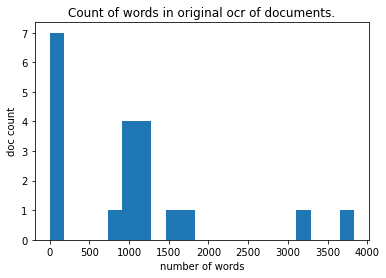

In [19]:
import matplotlib.pyplot as plt

#sort stuff
old_word_count.sort()
#build plot
plt.hist(old_word_count,bins=21)
plt.xlabel('number of words')
plt.ylabel('doc count')
plt.title('Count of words in original ocr of documents.')
plt.show()

<a id='7.1'></a>
### 7.1 Visualization summary

The above visualization depicts the count of words per document in the original ocr. Note, there are outliers in this output. Some of the extractions did not go in as planned. Seven documents have a very low word counts, which is unlikely and probablly a result of poor pdf metadata.

<a id='8.1'></a>
### 8.1 Visualization of a independent variable

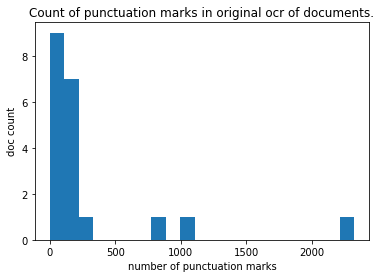

In [20]:
#sort stuff
old_punc_count.sort()
#build plot
plt.hist(old_punc_count,bins=21)
plt.xlabel('number of punctuation marks')
plt.ylabel('doc count')
plt.title('Count of punctuation marks in original ocr of documents.')
plt.show()

<a id='9.1'></a>
### 9.1 Visualization summary 2

The above visualization depicts the count of punctuation per document in the original ocr. Note like in the previous viz,several documents have a very low counts, which is unlikely and probablly a result of poor pdf metadata.

<a id='10.1'></a>
### 10.1 Bivariate relationship

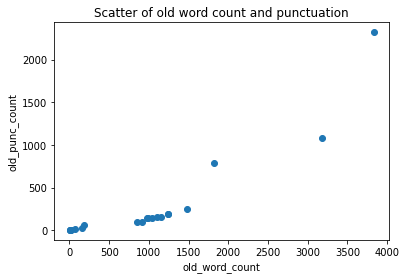

In [21]:
#build plot
plt.scatter(old_word_count,old_punc_count)
plt.xlabel('old_word_count')
plt.ylabel('old_punc_count')
plt.title('Scatter of old word count and punctuation')
plt.show()

<a id='11.1'></a>
### 11.1 Visualization summary 3

The above depicts what appears to ba  non-linear relationship between word count and punctuation count. 

<a id='12.1'></a>
### 12.1 Run bivarite regression of above dependent and independent variable.

In [16]:
#run bivariate model
import statsmodels.api as sm

df = pd.read_csv('ocr_10_page_extract_word_punc_char.csv')
y = df[['old_punc_count']]
x = df[['old_word_count']]
x = sm.add_constant(x)

#fit linear reg model
model = sm.OLS(y,x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         old_punc_count   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     74.53
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           8.15e-08
Time:                        06:38:37   Log-Likelihood:                -137.62
No. Observations:                  20   AIC:                             279.2
Df Residuals:                      18   BIC:                             281.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -192.2728     78.973     -2.

In [17]:
#multivariate regression

#load csv
df = pd.read_csv('ocr_10_page_extract_word_punc_char.csv')
old_punc_count = df['old_punc_count'].tolist()

#generate binary classifier, as a result of manual classification.
#NOTE: more on this decision in my Closing Thoghts section (#18.1)
#for demonstration of understanding I built a simple binary classifier 
#that divides the dataset into two parts, lots of punctuation (1) and not (0).

lots_of_punc = []
for doc in old_punc_count:
    if doc > 100:
        lots_of_punc.append(1)
    else:
        lots_of_punc.append(0)

df['lots_of_punc'] = lots_of_punc

#build model
y = df[['old_punc_count']]
x = df[['old_word_count','old_char_count','lots_of_punc']]
x = sm.add_constant(x)

#fit linear reg model
model = sm.OLS(y,x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         old_punc_count   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     41.08
Date:                Mon, 13 Dec 2021   Prob (F-statistic):           9.61e-08
Time:                        06:38:42   Log-Likelihood:                -132.36
No. Observations:                  20   AIC:                             272.7
Df Residuals:                      16   BIC:                             276.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -92.8082     72.732     -1.

(I couldn't figure out how to make a table in ipynb)

Table 3: Regression Results

Dependent variable: old_punc_count (count of words in origional ocr)

Independent Variable	Bivariate Model	    Multivariate Model
old_word_count             0.4790      			0.3975
						   (0.06)               (0.21)
old_char_count             				        0.0306
												(0.02)
  lots_of_punc                                  -418.78
	  											(126.99)

<a id='13.1'></a>
### 13.1 Control variable justification

My control variable's purpose, in the context of this dataset, is to assist in giving the user information on
if the document has a lot of punctuation or not. This is based on a calculation the user makes, which is consistent across individual records. Perhaps future work could include classification beyond 1 and 0. Specifically, including more classifiers, 0.1, 0.2, 0.3, etc.

<a id='14.1'></a>
### 14.1 Interpret the independent bivariate variable

An increase in punctuation count by one point results in an increase of word count by 47 points. Also, the chance this result is produced by random chance is less than 1 in 1000.  

<a id='15.1'></a>
### 15.1 Interpret the independent multivariate variable

Interestingly, in adding character count to the independent variable pool, along with word count we see the model break down. We're observing several orders of magnitude in reduction of significance, the result is now produced by random chance in 1 in 10.

<a id='16.1'></a>
### 16.1 Conduct a hypothesis test with the multivariate model

Ho: word count does not predict punctuation count.

Ha: word count predicts punctuation count. 

t-score: 1.794

Result of the test: we do not reject Ho but this does not necessarily mean we should accept it. In our bivariate model we see data to challenge this result. 

<a id='17.1'></a>
### 17.1 Overall findings

From my analysis I can confidently say that the subtilities in feature selection is a learned skill, one that comes though hours of practice and study. While I'm not entirely confident on my multivariate analysis, I think I am with my observations of the bivariate model. 

It makes sense that the two variables, word count and punctuation count, would be correlated. Perhaps not in a linear sence, but more of a exponential? At least from my prelimary plots that's what it looks like. If I had more documents and +10 page extractions I'm confident I'd be able to provide evidence of this. 


<a id='18.1'></a>
### 18.1 Closing thoughts:

There is a lot left unfished.

Exploring a true, complete, horizontal scaling of the script is at the top of that list. The main limiting factor preventing that is cost. Hosting such a thing on, say AWS for example, would cost hundreds of dollars. As a student I cannot make that happen. With that said however, I've nevertheless designed my code to be theoretically capable of being deployed relative to a computer’s core count. Meaning, if a cpu had 8 cores you could run up to ~6/7 instances of the extraction, indexed at different positions of the pdf list. This would result in reduced processing time. 

The second item on that list is to use the extraction in a formal document classification problem. This is a data access issue, as thousands of pdfs would be required to build the statistical strength in such a thing. I have a work project soon where I plan to do just this, and I'm looking forward to using this project’s framework to complete it.

Finally, I'd like to say I learned a lot from what I was able to accomplish. I've recognized I struggle with the classic statistics side of things, but with that aside this class has lit an unquenchable computer science fire in me and I thank you for that!

All my best,

-Carl